What to achieve:
- Run binary and get a good confusion matrix
  - Add a way to load the function
  - Restart and increase number of GPUs
  - Run the model for 17 more epochs

- See if I can save history.history as a dictionary
- Add the Google storage saving option so that I can run simultaneous



- Run multi-label (5 labels) and get a good confusion matrix on any
- Add callback to save weights and reimport them each time
- Add the VGG16 or Densenet50
- Make the presentation based on this
- Add anything else only afterwards


Bug - seems to be fixed for now
 - May be because there is a class with less than 128
      - just 5 of each - validation and other
      - just 128 of each - validation and other
      - a train with only 128 and the same validation that we have now
      - Same train that we have now except stopping at a multiple of 128
 - May be in the validation data
      - a train with only 128 and the same validation that we have now
 - Try

Solution
    - One issue seems to be in validation
     - tried traingen w/ 128 and validgen with 128. Got an error regarding shape not being an attribute of DataGenerator_single_class
     - tried the same thing without validation data and didn't get any issue.
     - therefor at least one problem is with the validation data step

    - One option is to skip the validation step

    - Currently just running everything as normal except using test and valid data equal to multiples of batch_size

In [59]:
# Checking GPU availability
from __future__ import absolute_import, division, print_function, unicode_literals #to check for gpu

# Custom libraries
from custom_libraries import file_saving
from custom_libraries import image_processing
from custom_libraries import import_data
from custom_libraries import model_support

# Standard libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Images
import pydicom
import cv2

# Batching for DataGenerator
from tensorflow.python.keras.utils.data_utils import Sequence

# Keras, Tensorflow and other model related
import tensorflow as tf
import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from sklearn.metrics import confusion_matrix
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

# Checking devices and system settings
import sys
print("Python: ", sys.version[:6])
print("Keras: ",keras.__version__)
print("Tensorflow: ",tf.__version__)
print("GPU Available: ",tf.test.is_gpu_available())
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print("\nAll devices:", *tf.config.experimental.list_physical_devices(),sep="\n")

# saving to cloud storage
from google.cloud import storage
from custom_libraries import gcloud_storage


Python:  3.5.3 
Keras:  2.3.0
Tensorflow:  2.0.0
GPU Available:  True
Num GPUs Available:  1

All devices:
PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')
PhysicalDevice(name='/physical_device:XLA_CPU:0', device_type='XLA_CPU')
PhysicalDevice(name='/physical_device:XLA_GPU:0', device_type='XLA_GPU')
PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


In [115]:
# Set global variables
batch_size=128
dim=(512,512)
data_path = "../data/"   # used when calling DataGenerator
random_seed = 12345


## Import Data and Create Data Generator

In [116]:
image_list = import_data.clean_data_csv(shuffle_data = True)
data = import_data.balanced_images_binary(image_list)
train_data, valid_data = train_test_split(data, test_size = 0.15, random_state = random_seed)

In [117]:
# bug fixing
train_data_excess = len(train_data) % batch_size
valid_data_excess = len(valid_data) % batch_size

train_data = train_data[:-train_data_excess]
valid_data = valid_data[:-valid_data_excess]

In [118]:
traingen=image_processing.DataGenerator_single_class(train_data,data_path = data_path, batch_size = batch_size)
validgen=image_processing.DataGenerator_single_class(valid_data,data_path = data_path, batch_size = batch_size)

In [119]:
train_data_test = train_data[0:batch_size*5]
valid_data_test = valid_data[0:batch_size*1]

traingen_test=image_processing.DataGenerator_single_class(train_data_test,data_path = data_path, batch_size = batch_size)
validgen_test=image_processing.DataGenerator_single_class(valid_data_test,data_path = data_path, batch_size = batch_size)

In [120]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 164992 entries, 168778 to 110024
Data columns (total 7 columns):
filename            164992 non-null object
any                 164992 non-null int64
epidural            164992 non-null int64
intraparenchymal    164992 non-null int64
intraventricular    164992 non-null int64
subarachnoid        164992 non-null int64
subdural            164992 non-null int64
dtypes: int64(6), object(1)
memory usage: 10.1+ MB


## Run Model

In [121]:
model_notes = "165k train images, balanced across any and none, binary, 512"
model_tags = ['binary', 'img_size:512']

In [122]:
# model_notes = "test, binary, 512"
# model_tags = ['binary', 'img_size:512', 'test']

In [ ]:
# # option to load previous model
# records = file_saving.load_model(records_output = True, model_output = False)
# last_record = list(records.model_path)[-1]
# loaded_model = file_saving.load_model(model_output = True, model_file_path = last_record)
# model = loaded_model

In [123]:
# Add weighted log loss - https://www.kaggle.com/akensert/inceptionv3-prev-resnet50-keras-baseline-model

model_notes = model_notes
model_tags = model_tags

model = Sequential()

model.add(Conv2D(32, (3, 3), input_shape=(dim[0], dim[1],1)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32,(3,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(5,5)))

model.add(Flatten())  

# model.add(Dense(100))
# model.add(Activation('relu'))

model.add(Dense(50))
model.add(Activation('relu'))

# for 6 classes
model.add(Dense(6, activation = 'sigmoid'))

# for 1 class
model.add(Dense(1, activation = 'sigmoid'))


# model.compile(loss='categorical_crossentropy',
# originally the above. Why use binary vs categorical

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
# model.compile(loss=focal_loss,
#                optimizer='adam',
#                metrics=['accuracy'])

Epoch 1/3
1289/1289 [==============================] - 2390s 2s/step - loss: 0.4970 - accuracy: 0.7541 - val_loss: 0.4613 - val_accuracy: 0.7769
Epoch 2/3
1289/1289 [==============================] - 2381s 2s/step - loss: 0.4066 - accuracy: 0.8154 - val_loss: 0.4002 - val_accuracy: 0.8192
Epoch 3/3
1289/1289 [==============================] - 2395s 2s/step - loss: 0.3239 - accuracy: 0.8616 - val_loss: 0.3614 - val_accuracy: 0.8420


,epochs,layers,model_name,model_notes,model_path,model_tags,num_layers,optimizer,score,timestamp,train_size,validation_size
23,1,[],2019-10-21T013017_model.h5,"test, binary, 512",models/2019-10-21T013017_model.h5,"{'keras', 'tensorflow'}",0,1,1,2019-10-21 01:30:17.505741,1,1
24,1,[],2019-10-21T013140_model.h5,"test, binary, 512",models/2019-10-21T013140_model.h5,"{'keras', 'tensorflow'}",0,1,1,2019-10-21 01:31:40.354051,1,1
25,1,[],2019-10-21T033555_model.h5,"165k train images, balanced across any and non...",models/2019-10-21T033555_model.h5,"{keras, tensorflow}",0,1,1,2019-10-21 03:35:55.310261,1,1


In [ ]:
# compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
# model.fit(X,y_train,batch_size=32,epochs=6,validation_split=0.5)
history=model.fit_generator(
    generator=traingen,
    validation_data=validgen,
    use_multiprocessing=True,
    workers=11,
    epochs=1)

file_saving.save_model(model, return_df=True, model_notes=model_notes).tail(3)

1288/1289 [============================>.] - ETA: 1s - loss: 0.2380 - accuracy: 0.9055

## Visualize Model Effectiveness

In [126]:
y_pred = model.predict_generator(generator=validgen,use_multiprocessing=True)

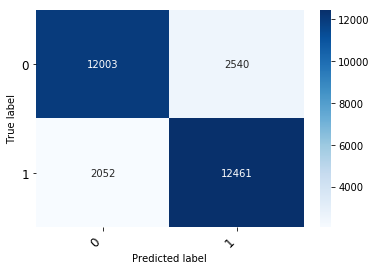

In [127]:
model_support.get_confusion_matrix(valid_data['any'],y_pred)

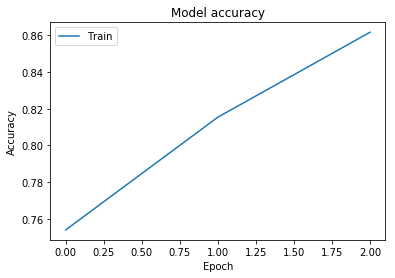

In [128]:
# plot accuracy

plt.plot(history.history['accuracy'])
# plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.savefig('models/latest_model_accuracy.png')
plt.show()


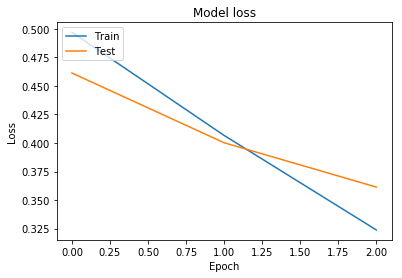

In [129]:
# plot loss

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.savefig('models/latest_model_loss.png')
plt.show()

## Loading Previous Models

In [18]:
# See df of most recent records
records = file_saving.load_model(records_output = True, model_output = False)
last_record = list(records.model_path)[-1]
records.tail(10)

,epochs,layers,model_name,model_notes,model_path,model_tags,num_layers,optimizer,score,timestamp,train_size,validation_size
8,1,[],2019-10-11T181803_model.h5,"test run with ~1000 images, using save_model(p...",models/2019-10-11T181803_model.h5,"{'keras', 'tensorflow'}",0,1,1,2019-10-11 18:18:03.877753,1,1
9,1,[],2019-10-13T224638_model.h5,test run with ~1000 images and ~200 valid size...,models/2019-10-13T224638_model.h5,"{'keras', 'tensorflow'}",0,1,1,2019-10-13 22:46:38.409506,1,1
10,1,[],2019-10-13T231208_model.h5,test run with ~1000 images and ~200 valid size...,models/2019-10-13T231208_model.h5,"{'keras', 'tensorflow'}",0,1,1,2019-10-13 23:12:08.724183,1,1
11,1,[],2019-10-14T153044_model.h5,test run with ~1000 images and ~200 valid size...,models/2019-10-14T153044_model.h5,"{'tensorflow', 'keras'}",0,1,1,2019-10-14 15:30:44.529041,1,1
12,1,[],2019-10-14T155036_model.h5,test run with ~1000 images and ~200 valid size...,models/2019-10-14T155036_model.h5,"{'tensorflow', 'keras'}",0,1,1,2019-10-14 15:50:36.173946,1,1
13,1,[],2019-10-14T174235_model.h5,test run with ~1000 images and ~200 valid size...,models/2019-10-14T174235_model.h5,"{'tensorflow', 'keras'}",0,1,1,2019-10-14 17:42:35.160266,1,1
14,1,[],2019-10-14T174315_model.h5,test run with ~1000 images and ~200 valid size...,models/2019-10-14T174315_model.h5,"{'tensorflow', 'keras'}",0,1,1,2019-10-14 17:43:15.894860,1,1
15,1,[],2019-10-14T193159_model.h5,testing,models/2019-10-14T193159_model.h5,"{'keras', 'tensorflow'}",0,1,1,2019-10-14 19:31:59.079340,1,1
16,1,[],2019-10-14T194331_model.h5,"24600 images, balanced across each category in...",models/2019-10-14T194331_model.h5,"{'keras', 'tensorflow'}",0,1,1,2019-10-14 19:43:31.080304,1,1
17,1,[],2019-10-19T020705_model.h5,test,models/2019-10-19T020705_model.h5,"{'keras', 'tensorflow'}",0,1,1,2019-10-19 02:07:05.253117,1,1


In [19]:
# load_model last model
_, loaded_model = file_saving.load_model(records_output = True, model_output = True, model_file_path = last_record)


# TESTING

#### Saving and loading models

In [58]:
# barebones function to save. Used for testing the save functions

model_path = 'models/2019-10-13T224638_model.h5'
# keras.models.save_model(model, model_path)
loaded_model = tf.keras.models.load_model(model_path)


In [318]:
# test = save_model(model, model_tags = [],return_df=True, model_notes="hello")
# test

worked-1
worked-2


,epochs,layers,model_name,model_notes,model_path,model_tags,num_layers,optimizer,score,timestamp,train_size,validation_size
0,1,[],2019-10-10T211053_model.h5,NaN,models/2019-10-10T211053_model.h5,"{'keras', 'tensorflow'}",0,1,1,2019-10-10 21:10:53.796514,1,1
1,1,[],2019-10-10T211056_model.h5,NaN,models/2019-10-10T211056_model.h5,"{'keras', 'tensorflow'}",0,1,1,2019-10-10 21:10:56.404866,1,1
2,1,[],2019-10-10T211112_model.h5,hello,models/2019-10-10T211112_model.h5,"{'keras', 'tensorflow'}",0,1,1,2019-10-10 21:11:12.708478,1,1
3,1,[],2019-10-10T211115_model.h5,hello,models/2019-10-10T211115_model.h5,"{'keras', 'tensorflow'}",0,1,1,2019-10-10 21:11:15.211067,1,1
4,1,[],2019-10-10T211116_model.h5,hello,models/2019-10-10T211116_model.h5,"{'keras', 'tensorflow'}",0,1,1,2019-10-10 21:11:16.248314,1,1
5,1,[],2019-10-10T211129_model.h5,hello,models/2019-10-10T211129_model.h5,"{keras, tensorflow}",0,1,1,2019-10-10 21:11:29.360498,1,1


In [286]:
# root = 'models/'
# save_as_type = 'h5' # can choose 'h5' or 'tf'
# model_records_path = root+'model_records.csv'

# df = pd.read_csv(model_records_path)
# df

,epochs,layers,model_name,model_path,model_tags,num_layers,optimizer,score,timestamp,train_size,validation_size
0,1,[],2019-10-10T202614_model.h5,models/2019-10-10T202614_model.h5,"{'keras', 'tensorflow'}",0,1,1,2019-10-10 20:26:14.109413,1,1
1,1,[],2019-10-10T202617_model.h5,models/2019-10-10T202617_model.h5,"{'keras', 'tensorflow'}",0,1,1,2019-10-10 20:26:17.506235,1,1
2,1,[],2019-10-10T202618_model.h5,models/2019-10-10T202618_model.h5,"{'keras', 'tensorflow'}",0,1,1,2019-10-10 20:26:18.759291,1,1
3,1,[],2019-10-10T202619_model.h5,models/2019-10-10T202619_model.h5,"{'keras', 'tensorflow'}",0,1,1,2019-10-10 20:26:19.641559,1,1
4,1,[],2019-10-10T202620_model.h5,models/2019-10-10T202620_model.h5,"{'keras', 'tensorflow'}",0,1,1,2019-10-10 20:26:20.819121,1,1
5,1,[],2019-10-10T202621_model.h5,models/2019-10-10T202621_model.h5,"{'keras', 'tensorflow'}",0,1,1,2019-10-10 20:26:21.808913,1,1
6,1,[],2019-10-10T202622_model.h5,models/2019-10-10T202622_model.h5,"{'keras', 'tensorflow'}",0,1,1,2019-10-10 20:26:22.799794,1,1
7,1,[],2019-10-10T202627_model.h5,models/2019-10-10T202627_model.h5,"{'keras', 'tensorflow'}",0,1,1,2019-10-10 20:26:27.330631,1,1


In [32]:
# Load model, if starting from a pre-made model
# root = 'models/'
# records_df, model = load_model(model_file_path="models/2019-10-11T004440_model.h5", model_output=True)

# from keras.initializers import glorot_uniform

# from keras.models import load_model
# from keras.utils import CustomObjectScope
# from keras.initializers import glorot_uniform
# with CustomObjectScope({'GlorotUniform': glorot_uniform()}):
#         loaded_model = keras.models.load_model('models/2019-10-11T004440_model.h5')

# model = keras.models.load_model('models/2019-10-11T004440_model.h5',custom_objects={"GlorotUniform": keras.initializers.glorot_uniform})

# custom_objects={"GlorotUniform": tf.keras.initializers.glorot_uniform}

# from keras.models import load_model
# from keras.utils import CustomObjectScope

# with CustomObjectScope({'GlorotUniform': glorot_uniform()}):

#         model = load_model('imdb_mlp_model.h5')

# root = 'models/'

# save_as_type = 'h5' # can choose 'h5' or 'tf'
# model_records_path = root+'model_records.csv'

# df = pd.read_csv(model_records_path)
# df


#### Time

In [112]:
import time
# import datetime
from datetime import datetime

In [194]:
# d = date.today()
from datetime import datetime
d = datetime.utcnow()
d.isoformat()
d.strftime("%Y-%m-%dT%H%M%S")

'2019-10-10T195147'